<a href="https://colab.research.google.com/github/toruuno/DNN_d1d2/blob/master/1_4_1_mnist_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')
sys.path.append('/content/drive/My Drive/common')
sys.path.append('/content/drive/My Drive/data')
sys.path.append('/content/drive/My Drive')

In [3]:
import numpy as np
from data.mnist import load_mnist
import pickle
from common import functions
import matplotlib.pyplot as plt

# mnistをロード
(x_train, d_train), (x_test, d_test) = load_mnist(normalize=True, one_hot_label=True)
train_size = len(x_train)

print("データ読み込み完了")

# 重み初期値補正係数
wieght_init = 0.01 # 変更してみよう
#入力層サイズ
input_layer_size = 784 # 変更してみよう
#中間層サイズ
hidden_layer_size = 40 # 変更してみよう
#出力層サイズ
output_layer_size = 10 # 変更してみよう
# 繰り返し数
iters_num = 1000 # 変更してみよう
# ミニバッチサイズ
batch_size = 100 # 変更してみよ
# 学習率
learning_rate = 0.1 # 変更してみよう
# 描写頻度
plot_interval=10

データ読み込み完了


# minst

In [4]:
# 初期設定
def init_network(mode=0):
    network = {} 

    if mode == 0:
      print("正規分布")
      network['W1'] = wieght_init * np.random.randn(input_layer_size, hidden_layer_size)
      network['W2'] = wieght_init * np.random.randn(hidden_layer_size, output_layer_size)
    elif mode == 1:
      print("Xavierの初期値")
      # 試してみよう_Xavierの初期値
      network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size)
      network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size)
    elif mode == 2:
      print("Heの初期値")
      # 試してみよう Heの初期値
      network['W1'] = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
      network['W2'] = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)
    else:
      return None  #未定義は故意にError誘導する

    network['b1'] = np.zeros(hidden_layer_size)
    network['b2'] = np.zeros(output_layer_size)

    return network

# 順伝播
def forward(network, x):
    W1, W2 = network['W1'], network['W2']
    b1, b2  = network['b1'], network['b2']
        
    u1 =  np.dot(x, W1) + b1
    z1 = functions.relu(u1)
    u2 =  np.dot(z1, W2) + b2
    y = functions.softmax(u2)
 
    return z1, y

# 誤差逆伝播
def backward(x, d, z1, y, network):
    grad = {}
    
    W1, W2 = network['W1'], network['W2']
    b1, b2 = network['b1'], network['b2']    
    # 出力層でのデルタ
    delta2 = functions.d_softmax_with_loss(d, y)
    # b2の勾配
    grad['b2'] = np.sum(delta2, axis=0)
    # W2の勾配
    grad['W2'] = np.dot(z1.T, delta2)
    # 1層でのデルタ
    delta1 = np.dot(delta2, W2.T) * functions.d_relu(z1)
    # b1の勾配
    grad['b1'] = np.sum(delta1, axis=0)
    # W1の勾配
    grad['W1'] = np.dot(x.T, delta1)

    return grad

# 正答率
def accuracy(x, d, network):
    z1, y = forward(network, x)
    y = np.argmax(y, axis=1)
    if d.ndim != 1 : d = np.argmax(d, axis=1)
    accuracy = np.sum(y == d) / float(x.shape[0])
    return accuracy

def mnist(mode=0):

    # パラメータの初期化
    network = init_network(mode)
    accuracies_train = []
    accuracies_test = []

    for i in range(iters_num):
        # ランダムにバッチを取得    
        batch_mask = np.random.choice(train_size, batch_size)
        # ミニバッチに対応する教師訓練画像データを取得    
        x_batch = x_train[batch_mask]
        # ミニバッチに対応する訓練正解ラベルデータを取得する
        d_batch = d_train[batch_mask]
        
        z1, y = forward(network, x_batch)
        grad = backward(x_batch, d_batch, z1, y, network)

        if (i+1)%plot_interval==0:
            accr_test = accuracy(x_test, d_test, network)
            accuracies_test.append(accr_test)
            
            accr_train = accuracy(x_batch, d_batch, network)
            accuracies_train.append(accr_train)

            print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
            print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))

        # パラメータに勾配適用
        for key in ('W1', 'W2', 'b1', 'b2'):
            network[key]  -= learning_rate * grad[key]


    lists = range(0, iters_num, plot_interval)
    plt.plot(lists, accuracies_train, label="training set")
    plt.plot(lists, accuracies_test,  label="test set")
    plt.legend(loc="lower right")
    plt.title("accuracy")   #日本語表示はgoogle colab上では少々面倒なので英語に変更しておく
    # グラフの表示
    plt.show()

# 「試してみよう」のその１としてネットワークの初期化を３通り変更してみた
# 最終的な正答率にほぼ相違はないけど学習初手の振る舞いにけっこうな相違がある
# (勾配消失し難くなる、という事か？)
# もっと差異を体感したいならば活性化関数を取り換える等も必要?
# 今回はそこまでは試さない

正規分布
Generation: 10. 正答率(トレーニング) = 0.23
                : 10. 正答率(テスト) = 0.1755
Generation: 20. 正答率(トレーニング) = 0.16
                : 20. 正答率(テスト) = 0.1137
Generation: 30. 正答率(トレーニング) = 0.28
                : 30. 正答率(テスト) = 0.2616
Generation: 40. 正答率(トレーニング) = 0.26
                : 40. 正答率(テスト) = 0.3075
Generation: 50. 正答率(トレーニング) = 0.28
                : 50. 正答率(テスト) = 0.336
Generation: 60. 正答率(トレーニング) = 0.53
                : 60. 正答率(テスト) = 0.4065
Generation: 70. 正答率(トレーニング) = 0.32
                : 70. 正答率(テスト) = 0.3647
Generation: 80. 正答率(トレーニング) = 0.48
                : 80. 正答率(テスト) = 0.488
Generation: 90. 正答率(トレーニング) = 0.65
                : 90. 正答率(テスト) = 0.5967
Generation: 100. 正答率(トレーニング) = 0.65
                : 100. 正答率(テスト) = 0.6412
Generation: 110. 正答率(トレーニング) = 0.69
                : 110. 正答率(テスト) = 0.7046
Generation: 120. 正答率(トレーニング) = 0.82
                : 120. 正答率(テスト) = 0.7483
Generation: 130. 正答率(トレーニング) = 0.71
                : 130. 正答率(テスト) = 0.7598
Generation: 14

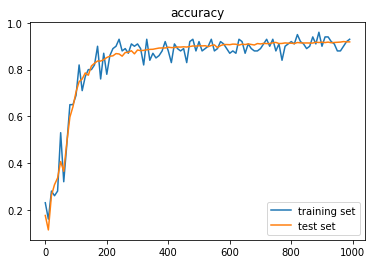

In [5]:
mnist(mode=0)

Xavierの初期値
Generation: 10. 正答率(トレーニング) = 0.51
                : 10. 正答率(テスト) = 0.4591
Generation: 20. 正答率(トレーニング) = 0.67
                : 20. 正答率(テスト) = 0.622
Generation: 30. 正答率(トレーニング) = 0.79
                : 30. 正答率(テスト) = 0.7503
Generation: 40. 正答率(トレーニング) = 0.72
                : 40. 正答率(テスト) = 0.7885
Generation: 50. 正答率(トレーニング) = 0.79
                : 50. 正答率(テスト) = 0.805
Generation: 60. 正答率(トレーニング) = 0.79
                : 60. 正答率(テスト) = 0.8345
Generation: 70. 正答率(トレーニング) = 0.78
                : 70. 正答率(テスト) = 0.8496
Generation: 80. 正答率(トレーニング) = 0.87
                : 80. 正答率(テスト) = 0.8588
Generation: 90. 正答率(トレーニング) = 0.85
                : 90. 正答率(テスト) = 0.8605
Generation: 100. 正答率(トレーニング) = 0.87
                : 100. 正答率(テスト) = 0.8762
Generation: 110. 正答率(トレーニング) = 0.9
                : 110. 正答率(テスト) = 0.8747
Generation: 120. 正答率(トレーニング) = 0.84
                : 120. 正答率(テスト) = 0.8751
Generation: 130. 正答率(トレーニング) = 0.86
                : 130. 正答率(テスト) = 0.8815
Generatio

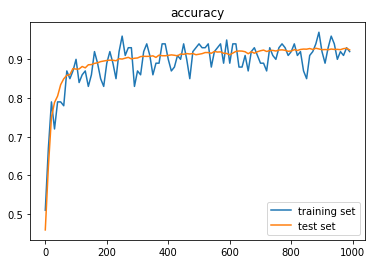

In [6]:
mnist(mode=1)

Heの初期値
Generation: 10. 正答率(トレーニング) = 0.52
                : 10. 正答率(テスト) = 0.465
Generation: 20. 正答率(トレーニング) = 0.73
                : 20. 正答率(テスト) = 0.7054
Generation: 30. 正答率(トレーニング) = 0.77
                : 30. 正答率(テスト) = 0.7892
Generation: 40. 正答率(トレーニング) = 0.8
                : 40. 正答率(テスト) = 0.8208
Generation: 50. 正答率(トレーニング) = 0.83
                : 50. 正答率(テスト) = 0.8379
Generation: 60. 正答率(トレーニング) = 0.85
                : 60. 正答率(テスト) = 0.8539
Generation: 70. 正答率(トレーニング) = 0.83
                : 70. 正答率(テスト) = 0.8584
Generation: 80. 正答率(トレーニング) = 0.85
                : 80. 正答率(テスト) = 0.8673
Generation: 90. 正答率(トレーニング) = 0.85
                : 90. 正答率(テスト) = 0.8707
Generation: 100. 正答率(トレーニング) = 0.79
                : 100. 正答率(テスト) = 0.8702
Generation: 110. 正答率(トレーニング) = 0.9
                : 110. 正答率(テスト) = 0.8791
Generation: 120. 正答率(トレーニング) = 0.88
                : 120. 正答率(テスト) = 0.8822
Generation: 130. 正答率(トレーニング) = 0.89
                : 130. 正答率(テスト) = 0.8854
Generation: 1

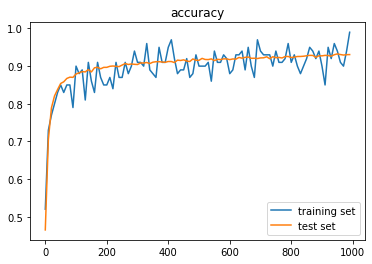

In [7]:
mnist(mode=2)

# 「試してみよう」のその２としてハイパーパラメータ弄りの実施
# 所望パラメータを弄って振る舞いを観察する(以下はデフォルト値のメモ)
    # 重み初期値補正係数
    wieght_init = 0.01 # 変更してみよう
    #入力層サイズ
    input_layer_size = 784 # 変更してみよう
    #中間層サイズ
    hidden_layer_size = 40 # 変更してみよう
    #出力層サイズ
    output_layer_size = 10 # 変更してみよう
    # 繰り返し数
    iters_num = 1000 # 変更してみよう
    # ミニバッチサイズ
    batch_size = 100 # 変更してみよ
    # 学習率
    learning_rate = 0.1 # 変更してみよう
    # 描写頻度
    plot_interval=10

正規分布
Generation: 10. 正答率(トレーニング) = 0.11
                : 10. 正答率(テスト) = 0.0974
Generation: 20. 正答率(トレーニング) = 0.09
                : 20. 正答率(テスト) = 0.0974
Generation: 30. 正答率(トレーニング) = 0.09
                : 30. 正答率(テスト) = 0.0974
Generation: 40. 正答率(トレーニング) = 0.07
                : 40. 正答率(テスト) = 0.0974
Generation: 50. 正答率(トレーニング) = 0.16
                : 50. 正答率(テスト) = 0.0974
Generation: 60. 正答率(トレーニング) = 0.07
                : 60. 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.09
                : 70. 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.13
                : 80. 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.1
                : 90. 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.12
                : 100. 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.1
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.13
                : 120. 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.12
                : 130. 正答率(テスト) = 0.1135
Generation: 14

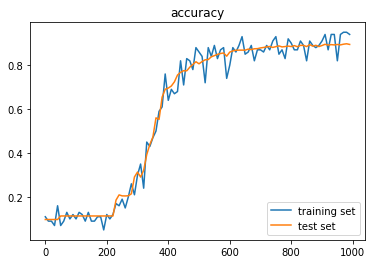

In [8]:
#ハイパーパラメータの変更
#まず初期値を大体0に誘導(学習初手で進み具合が悪くなる)
#結果的に指定のイテレーション数では学習が収束しないっぽい
#いわゆる勾配消失気味な状態
wieght_init = 0.0000001    # 0.01 # 変更してみよう
mnist(mode=0)
#弄ったパラメータはCell内で元にもどしましょう(以降同じく)
wieght_init = 0.01 # 変更してみよう

正規分布
Generation: 10. 正答率(トレーニング) = 0.16
                : 10. 正答率(テスト) = 0.1679
Generation: 20. 正答率(トレーニング) = 0.25
                : 20. 正答率(テスト) = 0.2997
Generation: 30. 正答率(トレーニング) = 0.24
                : 30. 正答率(テスト) = 0.2599
Generation: 40. 正答率(トレーニング) = 0.31
                : 40. 正答率(テスト) = 0.3535
Generation: 50. 正答率(トレーニング) = 0.43
                : 50. 正答率(テスト) = 0.3635
Generation: 60. 正答率(トレーニング) = 0.46
                : 60. 正答率(テスト) = 0.4029
Generation: 70. 正答率(トレーニング) = 0.41
                : 70. 正答率(テスト) = 0.4751
Generation: 80. 正答率(トレーニング) = 0.59
                : 80. 正答率(テスト) = 0.5639
Generation: 90. 正答率(トレーニング) = 0.66
                : 90. 正答率(テスト) = 0.6546
Generation: 100. 正答率(トレーニング) = 0.73
                : 100. 正答率(テスト) = 0.656
Generation: 110. 正答率(トレーニング) = 0.59
                : 110. 正答率(テスト) = 0.7051
Generation: 120. 正答率(トレーニング) = 0.75
                : 120. 正答率(テスト) = 0.7605
Generation: 130. 正答率(トレーニング) = 0.76
                : 130. 正答率(テスト) = 0.7677
Generation: 1

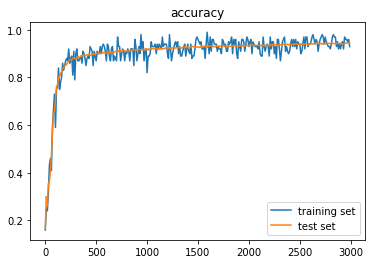

In [9]:
#ハイパーパラメータの変更
#イテレーションを三倍に
#収束はしてくれる&少し性能が上がる
iters_num = 3000    #1000 # 変更してみよう
mnist(mode=0)
iters_num = 1000 # 変更してみよう

正規分布
Generation: 10. 正答率(トレーニング) = 0.0
                : 10. 正答率(テスト) = 0.1446
Generation: 20. 正答率(トレーニング) = 0.1
                : 20. 正答率(テスト) = 0.2012
Generation: 30. 正答率(トレーニング) = 0.1
                : 30. 正答率(テスト) = 0.2992
Generation: 40. 正答率(トレーニング) = 0.2
                : 40. 正答率(テスト) = 0.2283
Generation: 50. 正答率(トレーニング) = 0.3
                : 50. 正答率(テスト) = 0.2622
Generation: 60. 正答率(トレーニング) = 0.5
                : 60. 正答率(テスト) = 0.3754
Generation: 70. 正答率(トレーニング) = 0.5
                : 70. 正答率(テスト) = 0.4021
Generation: 80. 正答率(トレーニング) = 0.5
                : 80. 正答率(テスト) = 0.4676
Generation: 90. 正答率(トレーニング) = 0.7
                : 90. 正答率(テスト) = 0.5385
Generation: 100. 正答率(トレーニング) = 0.8
                : 100. 正答率(テスト) = 0.5812
Generation: 110. 正答率(トレーニング) = 0.6
                : 110. 正答率(テスト) = 0.6234
Generation: 120. 正答率(トレーニング) = 0.6
                : 120. 正答率(テスト) = 0.6488
Generation: 130. 正答率(トレーニング) = 0.7
                : 130. 正答率(テスト) = 0.606
Generation: 140. 正答率(トレーニン

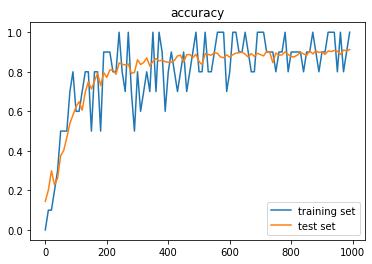

In [10]:
#ハイパーパラメータの変更
#バッチサイズの更新(小さくする)
#学習が荒くなり、かつ収束しにくくなるっぽい
batch_size = 10            #100 # 変更してみよ
mnist(mode=0)
batch_size = 100 # 変更してみよ

正規分布
Generation: 10. 正答率(トレーニング) = 0.13
                : 10. 正答率(テスト) = 0.0949
Generation: 20. 正答率(トレーニング) = 0.06
                : 20. 正答率(テスト) = 0.0949
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.0949
Generation: 40. 正答率(トレーニング) = 0.14
                : 40. 正答率(テスト) = 0.0949
Generation: 50. 正答率(トレーニング) = 0.1
                : 50. 正答率(テスト) = 0.0949
Generation: 60. 正答率(トレーニング) = 0.11
                : 60. 正答率(テスト) = 0.0949
Generation: 70. 正答率(トレーニング) = 0.07
                : 70. 正答率(テスト) = 0.0949
Generation: 80. 正答率(トレーニング) = 0.08
                : 80. 正答率(テスト) = 0.0949
Generation: 90. 正答率(トレーニング) = 0.08
                : 90. 正答率(テスト) = 0.0949
Generation: 100. 正答率(トレーニング) = 0.1
                : 100. 正答率(テスト) = 0.0949
Generation: 110. 正答率(トレーニング) = 0.11
                : 110. 正答率(テスト) = 0.0949
Generation: 120. 正答率(トレーニング) = 0.11
                : 120. 正答率(テスト) = 0.0949
Generation: 130. 正答率(トレーニング) = 0.08
                : 130. 正答率(テスト) = 0.095
Generation: 140

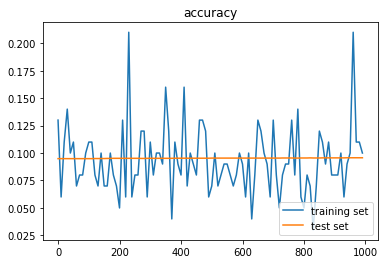

In [11]:
#ハイパーパラメータの変更
#学習率の変更(低くしてみる)
#当然だけど収束しにくくなる(というか全く進まなくなる)
learning_rate = 0.00001 #0.1 # 変更してみよう
mnist(mode=0)

正規分布
Generation: 10. 正答率(トレーニング) = 0.3
                : 10. 正答率(テスト) = 0.3699
Generation: 20. 正答率(トレーニング) = 0.36
                : 20. 正答率(テスト) = 0.3509
Generation: 30. 正答率(トレーニング) = 0.28
                : 30. 正答率(テスト) = 0.3352
Generation: 40. 正答率(トレーニング) = 0.55
                : 40. 正答率(テスト) = 0.567
Generation: 50. 正答率(トレーニング) = 0.52
                : 50. 正答率(テスト) = 0.5505
Generation: 60. 正答率(トレーニング) = 0.59
                : 60. 正答率(テスト) = 0.6244
Generation: 70. 正答率(トレーニング) = 0.65
                : 70. 正答率(テスト) = 0.6633
Generation: 80. 正答率(トレーニング) = 0.68
                : 80. 正答率(テスト) = 0.6203
Generation: 90. 正答率(トレーニング) = 0.83
                : 90. 正答率(テスト) = 0.8212
Generation: 100. 正答率(トレーニング) = 0.79
                : 100. 正答率(テスト) = 0.7374
Generation: 110. 正答率(トレーニング) = 0.83
                : 110. 正答率(テスト) = 0.8038
Generation: 120. 正答率(トレーニング) = 0.78
                : 120. 正答率(テスト) = 0.7753
Generation: 130. 正答率(トレーニング) = 0.7
                : 130. 正答率(テスト) = 0.8076
Generation: 140

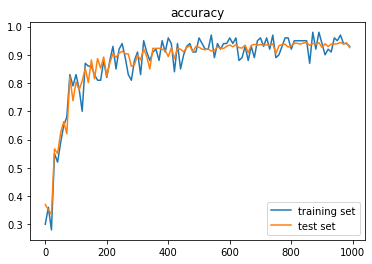

In [12]:
#ハイパーパラメータの変更
#学習率の変更(高くしてみる)
#このくらいならばよい結果を招く？
learning_rate = 1 #0.1 # 変更してみよう
mnist(mode=0)

正規分布
Generation: 10. 正答率(トレーニング) = 0.12
                : 10. 正答率(テスト) = 0.098
Generation: 20. 正答率(トレーニング) = 0.07
                : 20. 正答率(テスト) = 0.0982
Generation: 30. 正答率(トレーニング) = 0.06
                : 30. 正答率(テスト) = 0.0958
Generation: 40. 正答率(トレーニング) = 0.13
                : 40. 正答率(テスト) = 0.0974
Generation: 50. 正答率(トレーニング) = 0.13
                : 50. 正答率(テスト) = 0.1028
Generation: 60. 正答率(トレーニング) = 0.18
                : 60. 正答率(テスト) = 0.1028
Generation: 70. 正答率(トレーニング) = 0.05
                : 70. 正答率(テスト) = 0.0892
Generation: 80. 正答率(トレーニング) = 0.1
                : 80. 正答率(テスト) = 0.0974
Generation: 90. 正答率(トレーニング) = 0.06
                : 90. 正答率(テスト) = 0.1009
Generation: 100. 正答率(トレーニング) = 0.1
                : 100. 正答率(テスト) = 0.098
Generation: 110. 正答率(トレーニング) = 0.17
                : 110. 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.08
                : 120. 正答率(テスト) = 0.1009
Generation: 130. 正答率(トレーニング) = 0.15
                : 130. 正答率(テスト) = 0.0958
Generation: 140.

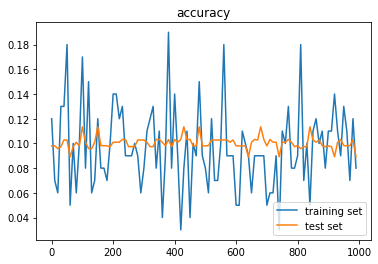

In [13]:
#ハイパーパラメータの変更
#学習率の変更(さらに高くしてみる)
#発散気味(やりすぎは良くないという事で)
learning_rate = 100 #0.1 # 変更してみよう
mnist(mode=0)
learning_rate = 0.1 # 変更してみよう

正規分布
Generation: 10. 正答率(トレーニング) = 0.18
                : 10. 正答率(テスト) = 0.1331
Generation: 20. 正答率(トレーニング) = 0.11
                : 20. 正答率(テスト) = 0.101
Generation: 30. 正答率(トレーニング) = 0.11
                : 30. 正答率(テスト) = 0.1172
Generation: 40. 正答率(トレーニング) = 0.18
                : 40. 正答率(テスト) = 0.1317
Generation: 50. 正答率(トレーニング) = 0.15
                : 50. 正答率(テスト) = 0.1169
Generation: 60. 正答率(トレーニング) = 0.19
                : 60. 正答率(テスト) = 0.1748
Generation: 70. 正答率(トレーニング) = 0.1
                : 70. 正答率(テスト) = 0.1281
Generation: 80. 正答率(トレーニング) = 0.2
                : 80. 正答率(テスト) = 0.1629
Generation: 90. 正答率(トレーニング) = 0.22
                : 90. 正答率(テスト) = 0.2013
Generation: 100. 正答率(トレーニング) = 0.21
                : 100. 正答率(テスト) = 0.2447
Generation: 110. 正答率(トレーニング) = 0.36
                : 110. 正答率(テスト) = 0.3077
Generation: 120. 正答率(トレーニング) = 0.31
                : 120. 正答率(テスト) = 0.3287
Generation: 130. 正答率(トレーニング) = 0.38
                : 130. 正答率(テスト) = 0.4061
Generation: 140

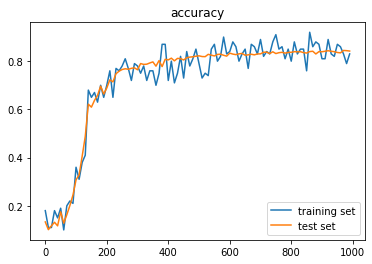

In [14]:
#最後にネットワークそのものの変更だけど
#入力層は画素数に合わせないとダメなので変更なしとする
#出力層はラベル数に合わせないとダメ(要するに0から9の数字分類モデルだから)なのでこれも変更なし
#(というようないわゆる引っ掛け問題と解釈、まぁ入力層は画素数変えれば弄れなくはないけどそれはやらない)
#ということでいじれる余地は中間層の構成くらいとして実験
#
#まずは貧弱にしてみる
#やはり性能は落ちる
hidden_layer_size = 4 #40 # 変更してみよう
mnist(mode=0)

正規分布
Generation: 10. 正答率(トレーニング) = 0.41
                : 10. 正答率(テスト) = 0.379
Generation: 20. 正答率(トレーニング) = 0.38
                : 20. 正答率(テスト) = 0.2723
Generation: 30. 正答率(トレーニング) = 0.32
                : 30. 正答率(テスト) = 0.3495
Generation: 40. 正答率(トレーニング) = 0.56
                : 40. 正答率(テスト) = 0.5689
Generation: 50. 正答率(トレーニング) = 0.65
                : 50. 正答率(テスト) = 0.6244
Generation: 60. 正答率(トレーニング) = 0.67
                : 60. 正答率(テスト) = 0.6735
Generation: 70. 正答率(トレーニング) = 0.7
                : 70. 正答率(テスト) = 0.7349
Generation: 80. 正答率(トレーニング) = 0.68
                : 80. 正答率(テスト) = 0.7234
Generation: 90. 正答率(トレーニング) = 0.81
                : 90. 正答率(テスト) = 0.7972
Generation: 100. 正答率(トレーニング) = 0.84
                : 100. 正答率(テスト) = 0.7941
Generation: 110. 正答率(トレーニング) = 0.83
                : 110. 正答率(テスト) = 0.8164
Generation: 120. 正答率(トレーニング) = 0.84
                : 120. 正答率(テスト) = 0.8309
Generation: 130. 正答率(トレーニング) = 0.84
                : 130. 正答率(テスト) = 0.8335
Generation: 14

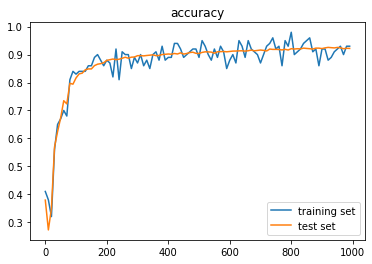

In [15]:
#最後にネットワークそのものの変更だけど
#中間層をリッチにしてみる
#少しだけ学習の収束点が早まるかもしれず
#&少しだけ各イテレーションでの学習とテストの誤差が減る?
hidden_layer_size = 240 #40 # 変更してみよう
mnist(mode=0)

Heの初期値
Generation: 10. 正答率(トレーニング) = 0.69
                : 10. 正答率(テスト) = 0.6836
Generation: 20. 正答率(トレーニング) = 0.83
                : 20. 正答率(テスト) = 0.8144
Generation: 30. 正答率(トレーニング) = 0.87
                : 30. 正答率(テスト) = 0.8635
Generation: 40. 正答率(トレーニング) = 0.82
                : 40. 正答率(テスト) = 0.829
Generation: 50. 正答率(トレーニング) = 0.87
                : 50. 正答率(テスト) = 0.8809
Generation: 60. 正答率(トレーニング) = 0.86
                : 60. 正答率(テスト) = 0.8833
Generation: 70. 正答率(トレーニング) = 0.93
                : 70. 正答率(テスト) = 0.8936
Generation: 80. 正答率(トレーニング) = 0.88
                : 80. 正答率(テスト) = 0.9115
Generation: 90. 正答率(トレーニング) = 0.87
                : 90. 正答率(テスト) = 0.8776
Generation: 100. 正答率(トレーニング) = 0.92
                : 100. 正答率(テスト) = 0.9129
Generation: 110. 正答率(トレーニング) = 0.87
                : 110. 正答率(テスト) = 0.9178
Generation: 120. 正答率(トレーニング) = 0.9
                : 120. 正答率(テスト) = 0.9013
Generation: 130. 正答率(トレーニング) = 0.92
                : 130. 正答率(テスト) = 0.922
Generation: 1

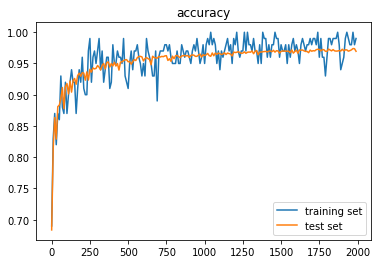

In [16]:
#追試で性能向上っぽいことも
#交差検証したいけど時間かかりそうなのでエイやで
#97%とかの数字が出てはいる
#この数字が妥当かどうかはコメントしない

#中間層サイズ
hidden_layer_size = 120 # 変更してみよう
# 繰り返し数
iters_num = 2000 # 変更してみよう
# 学習率
learning_rate = 0.5 # 変更してみよう

mnist(mode=2)  #ネットワークのw初期値もHe初期化で一応最適に